<a href="https://colab.research.google.com/github/SNMHZ/finedust_predict/blob/master/%EB%AF%B8%EC%84%B8%EB%A8%BC%EC%A7%80_0130.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 / 데이터 로드

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [3]:
import matplotlib.pyplot as plt

In [119]:
import tensorflow as tf

In [4]:
#2003년도부터 2017년도까지 미세먼지 데이터 로딩
DUST_DF_DICT={}
for i in range(15):
  DUST_DF_DICT['DUST_%d'%(i+2003)]=pd.read_csv('https://github.com/SNMHZ/finedust_predict/raw/master/dataset/%d.csv'%(i+2003), encoding='EUC_KR')

# 금일 작업


## 아웃라이어 제거 전 모든 과정 쭉

In [60]:
#2017년 데이터에서 수창동 데이터만 뽑는 작업
#왜 신암동만 뽑았나? 학교랑 제일 가까운 동네임
dust2017=DUST_DF_DICT['DUST_2017'].copy()
shinamdong=dust2017.loc[dust2017['측정소명'].where(dust2017['측정소명']=='신암동').dropna().index]
shinamdong

,측정소명,년,월,일,시,SO2,PM10,PM25,O3,NO2,CO
6,신암동,2017,1,1,1,0.003,50,30,0.002,0.037,0.9
17,신암동,2017,1,1,2,0.003,46,31,0.002,0.034,0.8
28,신암동,2017,1,1,3,0.002,40,29,0.002,0.031,0.7
39,신암동,2017,1,1,4,0.002,40,27,0.002,0.030,0.8
50,신암동,2017,1,1,5,0.004,37,29,0.002,0.029,0.9
...,...,...,...,...,...,...,...,...,...,...,...
96420,신암동,2017,12,31,20,0.004,62,20,0.029,0.017,0.4
96433,신암동,2017,12,31,21,0.004,55,22,0.030,0.016,0.4
96446,신암동,2017,12,31,22,0.005,54,16,0.023,0.023,0.4
96459,신암동,2017,12,31,23,0.005,56,19,0.022,0.024,0.4


In [61]:
#신암동 1시간 후 데이터 밀어서 목표 데이터셋 생성
shinamdong['PM10_res']=shinamdong['PM10'].shift(-1)
shinamdong['PM25_res']=shinamdong['PM25'].shift(-1)
shinamdong

,측정소명,년,월,일,시,SO2,PM10,PM25,O3,NO2,CO,PM10_res,PM25_res
6,신암동,2017,1,1,1,0.003,50,30,0.002,0.037,0.9,46.0,31.0
17,신암동,2017,1,1,2,0.003,46,31,0.002,0.034,0.8,40.0,29.0
28,신암동,2017,1,1,3,0.002,40,29,0.002,0.031,0.7,40.0,27.0
39,신암동,2017,1,1,4,0.002,40,27,0.002,0.030,0.8,37.0,29.0
50,신암동,2017,1,1,5,0.004,37,29,0.002,0.029,0.9,45.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96420,신암동,2017,12,31,20,0.004,62,20,0.029,0.017,0.4,55.0,22.0
96433,신암동,2017,12,31,21,0.004,55,22,0.030,0.016,0.4,54.0,16.0
96446,신암동,2017,12,31,22,0.005,54,16,0.023,0.023,0.4,56.0,19.0
96459,신암동,2017,12,31,23,0.005,56,19,0.022,0.024,0.4,50.0,17.0


In [62]:
#한칸 밀었으니 마지막줄 없애버리기 
#-> 데이터셋 기본 전처리(1시간 후 PM10 갖다 붙이기) 완료.
shinamdong=shinamdong[:-1]
shinamdong

,측정소명,년,월,일,시,SO2,PM10,PM25,O3,NO2,CO,PM10_res,PM25_res
6,신암동,2017,1,1,1,0.003,50,30,0.002,0.037,0.9,46.0,31.0
17,신암동,2017,1,1,2,0.003,46,31,0.002,0.034,0.8,40.0,29.0
28,신암동,2017,1,1,3,0.002,40,29,0.002,0.031,0.7,40.0,27.0
39,신암동,2017,1,1,4,0.002,40,27,0.002,0.030,0.8,37.0,29.0
50,신암동,2017,1,1,5,0.004,37,29,0.002,0.029,0.9,45.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96407,신암동,2017,12,31,19,0.004,66,18,0.034,0.014,0.4,62.0,20.0
96420,신암동,2017,12,31,20,0.004,62,20,0.029,0.017,0.4,55.0,22.0
96433,신암동,2017,12,31,21,0.004,55,22,0.030,0.016,0.4,54.0,16.0
96446,신암동,2017,12,31,22,0.005,54,16,0.023,0.023,0.4,56.0,19.0


In [67]:
#단순 선형회귀로 먼저 테스트 해보기
#학습 데이터셋, 결과 데이터셋 만들기
#학습용(현재 PM10), 결과(1시간 후 PM10) 
X = shinamdong[['PM10']].copy()
y = shinamdong[['PM10_res']].copy()

In [70]:
#(현재 PM10), (1시간 후 PM10) 두 가지로 단순 선형회귀(모델 자체 정규화 이용)
#이후 점수 확인. -> 결과 개판
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
model = LinearRegression(normalize=True)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.24720023262267699

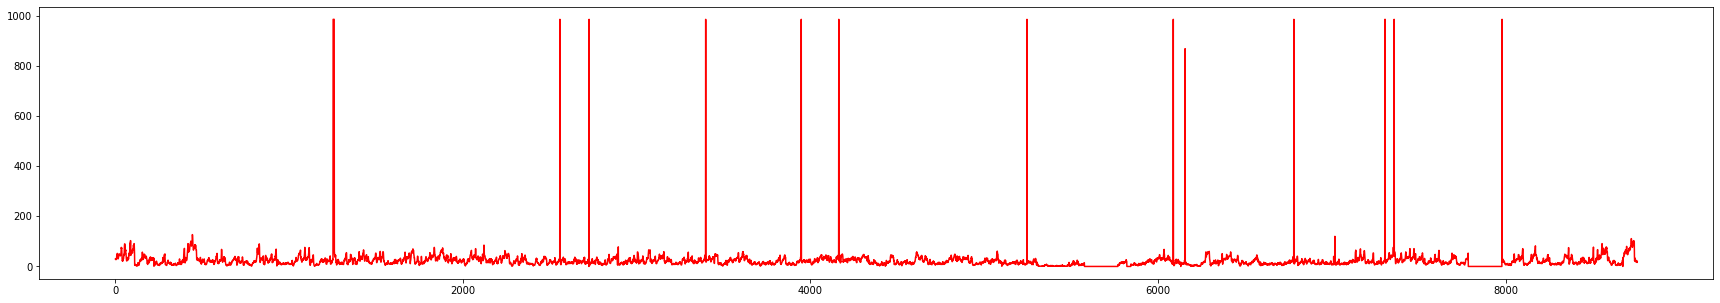

In [59]:
plt.figure(figsize=(30, 5))
plt.plot(shinamdong[['PM25']].reset_index().index, shinamdong[['PM25']].reset_index()['PM25'], color='red')
#plt.plot(X.reset_index().index, model.predict(X), color='blue',)

plt.show()

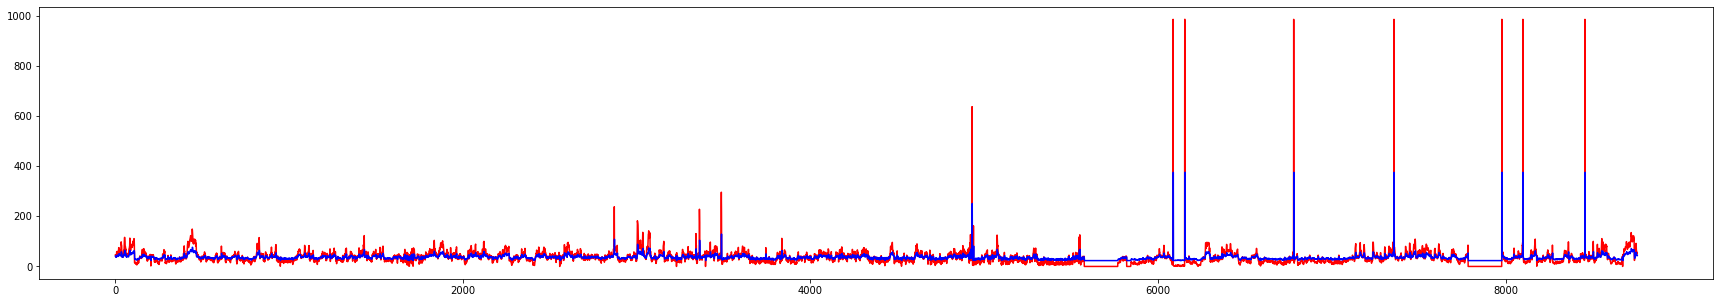

In [10]:
plt.figure(figsize=(30, 5))
plt.plot(X.reset_index().index, y.reset_index()['PM10_res'], color='red')
plt.plot(X.reset_index().index, model.predict(X), color='blue',)

plt.show()

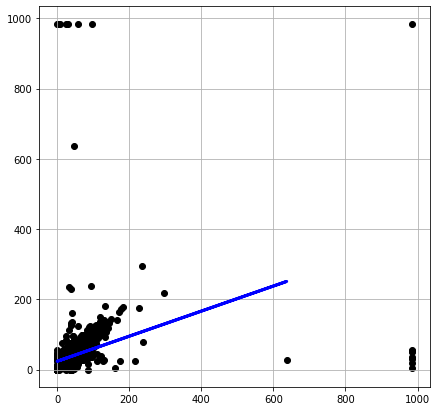

In [11]:
#어떻게 회귀가 되었는지 그래프를 그려보았다.
#->아웃라이어 제거의 필요성을 느꼈다
plt.figure(figsize=(7, 7))
plt.grid(True)
plt.scatter(shinamdong['PM10'], shinamdong['PM10_res'],  color='black')
plt.plot(X_test, model.predict(X_test), color='blue', linewidth=3)

plt.show()

## 아웃라이어 처리 방법 선택 이유

아웃라이어 처리 방법으로는 winsorize, trim이 대표적이다

우리는 trim방법을 사용했다 왜?

0~30㎛/㎥(좋음)

31~80㎛/㎥(보통)	

81~150㎛/㎥(나쁨)	

151㎛/㎥ 이상(매우나쁨)

이 기준인데 최고 값에서 같은 값이 자주 나타나는 것을 목격할 수 있었다.

기계 오작동으로 인한 잘못된 측정으로 추정되어, trim 기법을 이용하기로 했다.

또한, 매우 나쁨 기준치의 4배 이상씩 되는 수치도 주변에서 모래를 뿌리거나 기계 오작동 등 정상적이지 않은 상황으로 추정하여 같이 trim하기로 결정하였다.

그래서 어디를 기준으로 자를 것인치 결정하기로 했다.

### 처리 후 산포도 그림들

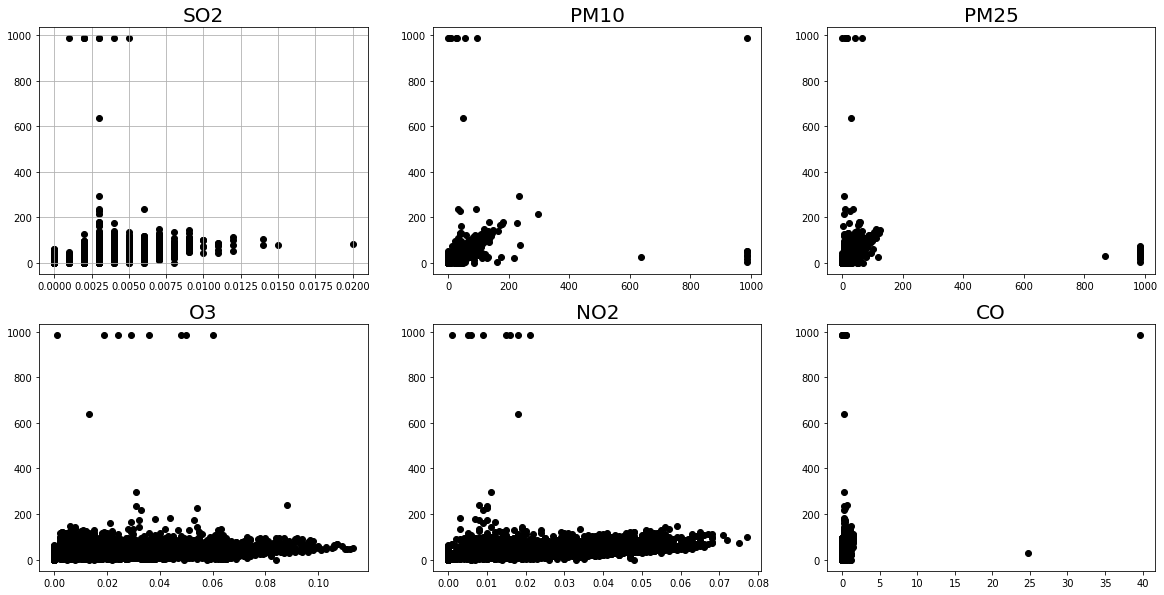

In [51]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.title('SO2', size = 20,)
plt.grid(True)
plt.scatter(shinamdong['SO2'], shinamdong['PM10_res'],  color='black')

plt.subplot(232)
plt.title('PM10', size = 20,)
plt.scatter(shinamdong['PM10'], shinamdong['PM10_res'],  color='black')

plt.subplot(233)
plt.title('PM25', size = 20,)
plt.scatter(shinamdong['PM25'], shinamdong['PM10_res'],  color='black')

plt.subplot(234)
plt.title('O3', size = 20,)
plt.scatter(shinamdong['O3'], shinamdong['PM10_res'],  color='black')

plt.subplot(235)
plt.title('NO2', size = 20,)
plt.scatter(shinamdong['NO2'], shinamdong['PM10_res'],  color='black')

plt.subplot(236)
plt.title('CO', size = 20,)
plt.scatter(shinamdong['CO'], shinamdong['PM10_res'],  color='black')
plt.show()

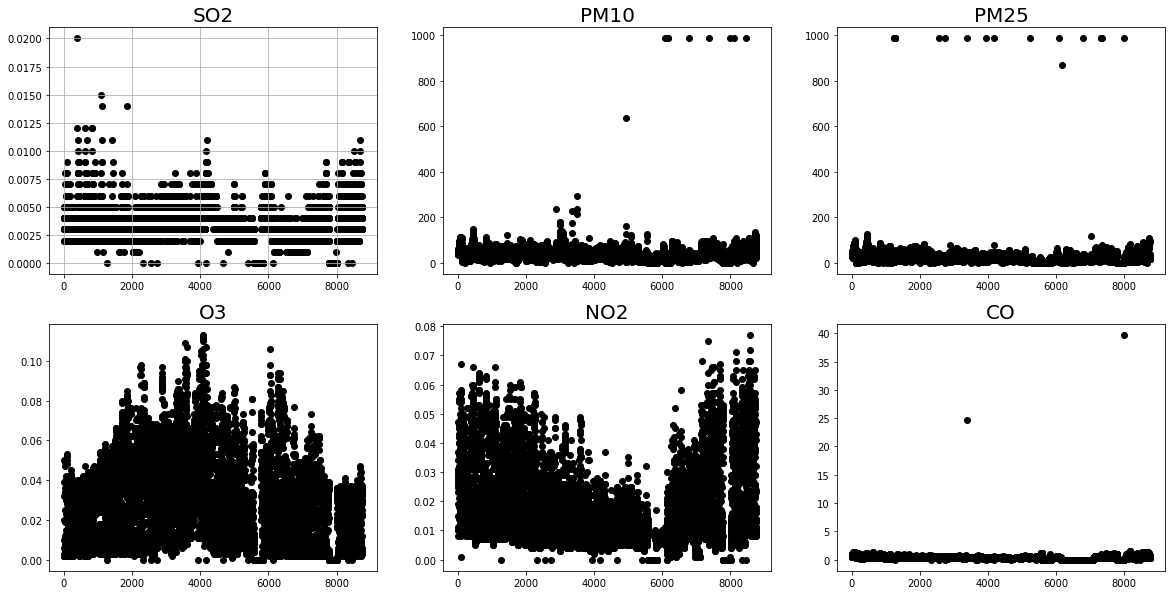

In [54]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.title('SO2', size = 20,)
plt.grid(True)
plt.scatter(shinamdong.reset_index().index, shinamdong['SO2'],  color='black')

plt.subplot(232)
plt.title('PM10', size = 20,)
plt.scatter(shinamdong.reset_index().index, shinamdong['PM10'],  color='black')

plt.subplot(233)
plt.title('PM25', size = 20,)
plt.scatter(shinamdong.reset_index().index, shinamdong['PM25'],  color='black')

plt.subplot(234)
plt.title('O3', size = 20,)
plt.scatter(shinamdong.reset_index().index, shinamdong['O3'],  color='black')

plt.subplot(235)
plt.title('NO2', size = 20,)
plt.scatter(shinamdong.reset_index().index, shinamdong['NO2'],  color='black')

plt.subplot(236)
plt.title('CO', size = 20,)
plt.scatter(shinamdong.reset_index().index, shinamdong['CO'],  color='black')
plt.show()

In [91]:
#PM10 400이상 & 0 날리기
shinamdong_drop = shinamdong[ (shinamdong['PM10']<400) & (shinamdong['PM10_res']<400) ]
shinamdong_drop = shinamdong_drop[ (shinamdong_drop['PM10']!=0) & (shinamdong_drop['PM10_res']!=0) ]
#PM10 400이상 & 0 날리기
shinamdong_drop = shinamdong_drop[ (shinamdong_drop['PM25']<400) & (shinamdong_drop['PM25_res']<400) ]
shinamdong_drop = shinamdong_drop[ (shinamdong_drop['PM25']!=0) & (shinamdong_drop['PM25_res']!=0) ]

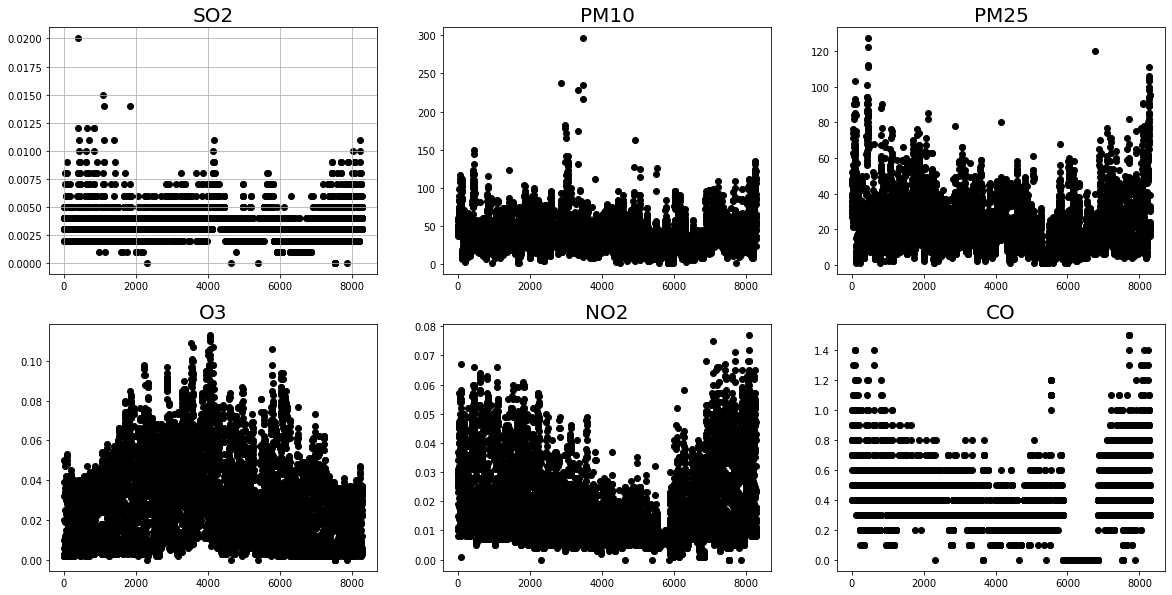

In [92]:
#CO에 이상 있는거 확인하기. 센서 고장으로 추정됨.
fig = plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.title('SO2', size = 20,)
plt.grid(True)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['SO2'],  color='black')

plt.subplot(232)
plt.title('PM10', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['PM10'],  color='black')

plt.subplot(233)
plt.title('PM25', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['PM25'],  color='black')

plt.subplot(234)
plt.title('O3', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['O3'],  color='black')

plt.subplot(235)
plt.title('NO2', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['NO2'],  color='black')

plt.subplot(236)
plt.title('CO', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['CO'],  color='black')
plt.show()

In [93]:
#PM10 400이상 & 0 날리기
shinamdong_drop = shinamdong[ (shinamdong['PM10']<400) & (shinamdong['PM10_res']<400) ]
shinamdong_drop = shinamdong_drop[ (shinamdong_drop['PM10']!=0) & (shinamdong_drop['PM10_res']!=0) ]
#PM10 400이상 & 0 날리기
shinamdong_drop = shinamdong_drop[ (shinamdong_drop['PM25']<400) & (shinamdong_drop['PM25_res']<400) ]
shinamdong_drop = shinamdong_drop[ (shinamdong_drop['PM25']!=0) & (shinamdong_drop['PM25_res']!=0) ]
#기타 대기 인자 0 날리기
shinamdong_drop = shinamdong_drop[ (shinamdong_drop['SO2']!=0) ]
shinamdong_drop = shinamdong_drop[ (shinamdong_drop['O3']!=0) ]
shinamdong_drop = shinamdong_drop[ (shinamdong_drop['NO2']!=0) ]
shinamdong_drop = shinamdong_drop[ (shinamdong_drop['CO']!=0) ]

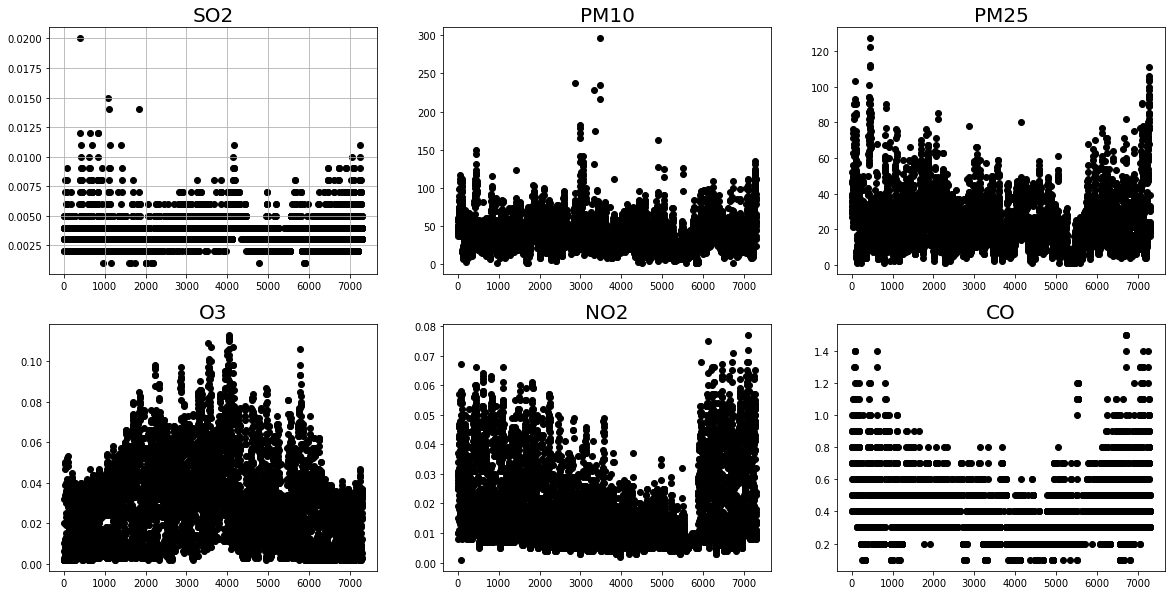

In [87]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.title('SO2', size = 20,)
plt.grid(True)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['SO2'],  color='black')

plt.subplot(232)
plt.title('PM10', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['PM10'],  color='black')

plt.subplot(233)
plt.title('PM25', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['PM25'],  color='black')

plt.subplot(234)
plt.title('O3', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['O3'],  color='black')

plt.subplot(235)
plt.title('NO2', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['NO2'],  color='black')

plt.subplot(236)
plt.title('CO', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['CO'],  color='black')
plt.show()

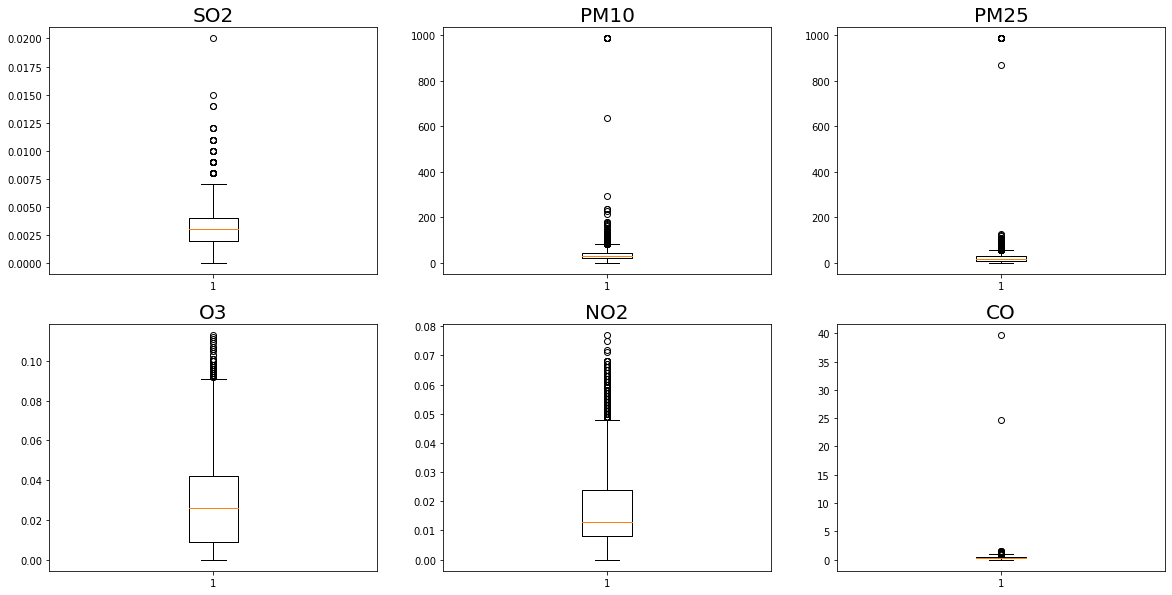

In [47]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.title('SO2', size = 20,)
plt.boxplot(shinamdong['SO2'])

plt.subplot(232)
plt.title('PM10', size = 20,)
plt.boxplot(shinamdong['PM10'])

plt.subplot(233)
plt.title('PM25', size = 20,)
plt.boxplot(shinamdong['PM25'])

plt.subplot(234)
plt.title('O3', size = 20,)
plt.boxplot(shinamdong['O3'])

plt.subplot(235)
plt.title('NO2', size = 20,)
plt.boxplot(shinamdong['NO2'])

plt.subplot(236)
plt.title('CO', size = 20,)
plt.boxplot(shinamdong['CO'])
plt.show()

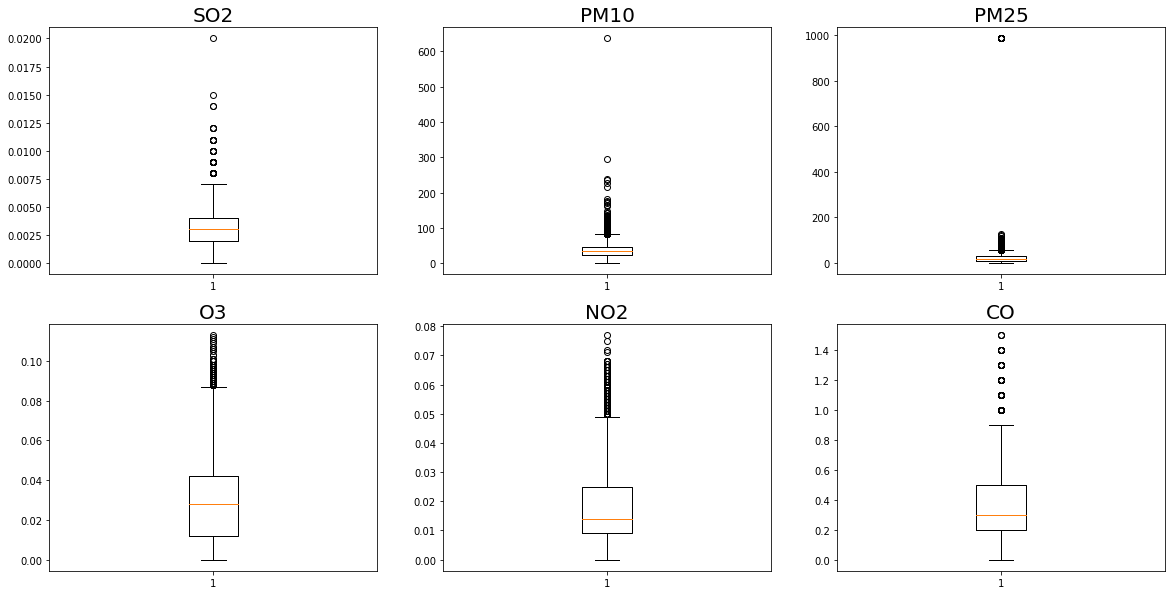

In [50]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.title('SO2', size = 20,)
plt.boxplot(shinamdong_drop['SO2'])

plt.subplot(232)
plt.title('PM10', size = 20,)
plt.boxplot(shinamdong_drop['PM10'])

plt.subplot(233)
plt.title('PM25', size = 20,)
plt.boxplot(shinamdong_drop['PM25'])

plt.subplot(234)
plt.title('O3', size = 20,)
plt.boxplot(shinamdong_drop['O3'])

plt.subplot(235)
plt.title('NO2', size = 20,)
plt.boxplot(shinamdong_drop['NO2'])

plt.subplot(236)
plt.title('CO', size = 20,)
plt.boxplot(shinamdong_drop['CO'])
plt.show()

### 처리 후 선형회귀

In [99]:
shinamdong_drop.head(3)

,측정소명,년,월,일,시,SO2,PM10,PM25,O3,NO2,CO,PM10_res,PM25_res
6,신암동,2017,1,1,1,0.003,50,30,0.002,0.037,0.9,46.0,31.0
17,신암동,2017,1,1,2,0.003,46,31,0.002,0.034,0.8,40.0,29.0
28,신암동,2017,1,1,3,0.002,40,29,0.002,0.031,0.7,40.0,27.0


In [98]:
len(shinamdong_drop)

7310

In [100]:
#단순 선형회귀로 먼저 테스트 해보기
#학습 데이터셋, 결과 데이터셋 만들기
#학습용(현재 PM10), 결과(1시간 후 PM10) 
X = shinamdong_drop[['PM10']].copy()
y = shinamdong_drop[['PM10_res']].copy()

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
model = LinearRegression(normalize=True)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8044454567825785

In [111]:
model.predict([[1], [max(shinamdong_drop['PM10'])]])

array([[  6.71077751],
       [256.73413915]])

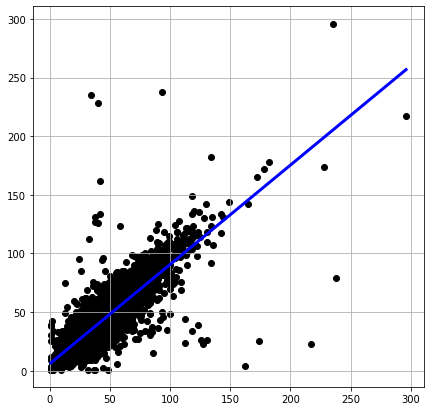

In [116]:
plt.figure(figsize=(7, 7))
plt.grid(True)
plt.scatter(shinamdong_drop['PM10'], shinamdong_drop['PM10_res'],  color='black')
linex = [ [min(shinamdong_drop['PM10'])], [max(shinamdong_drop['PM10'])] ]
plt.plot(linex, model.predict(linex), color='blue', linewidth=3)

plt.show()

In [ ]:
plt.figure(figsize=(7, 7))
plt.grid(True)

plt.scatter(shinamdong_drop['PM10'], shinamdong_drop['PM10_res'],  color='black')
linex = [ [min(shinamdong_drop['PM10'])], [max(shinamdong_drop['PM10'])] ]
plt.plot(linex, model.predict(linex), color='blue', linewidth=3)

plt.show()

In [ ]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.title('SO2', size = 20,)
plt.grid(True)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['SO2'],  color='black')

plt.subplot(232)
plt.title('PM10', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['PM10'],  color='black')

plt.subplot(233)
plt.title('PM25', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['PM25'],  color='black')

plt.subplot(234)
plt.title('O3', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['O3'],  color='black')

plt.subplot(235)
plt.title('NO2', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['NO2'],  color='black')

plt.subplot(236)
plt.title('CO', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['CO'],  color='black')
plt.show()

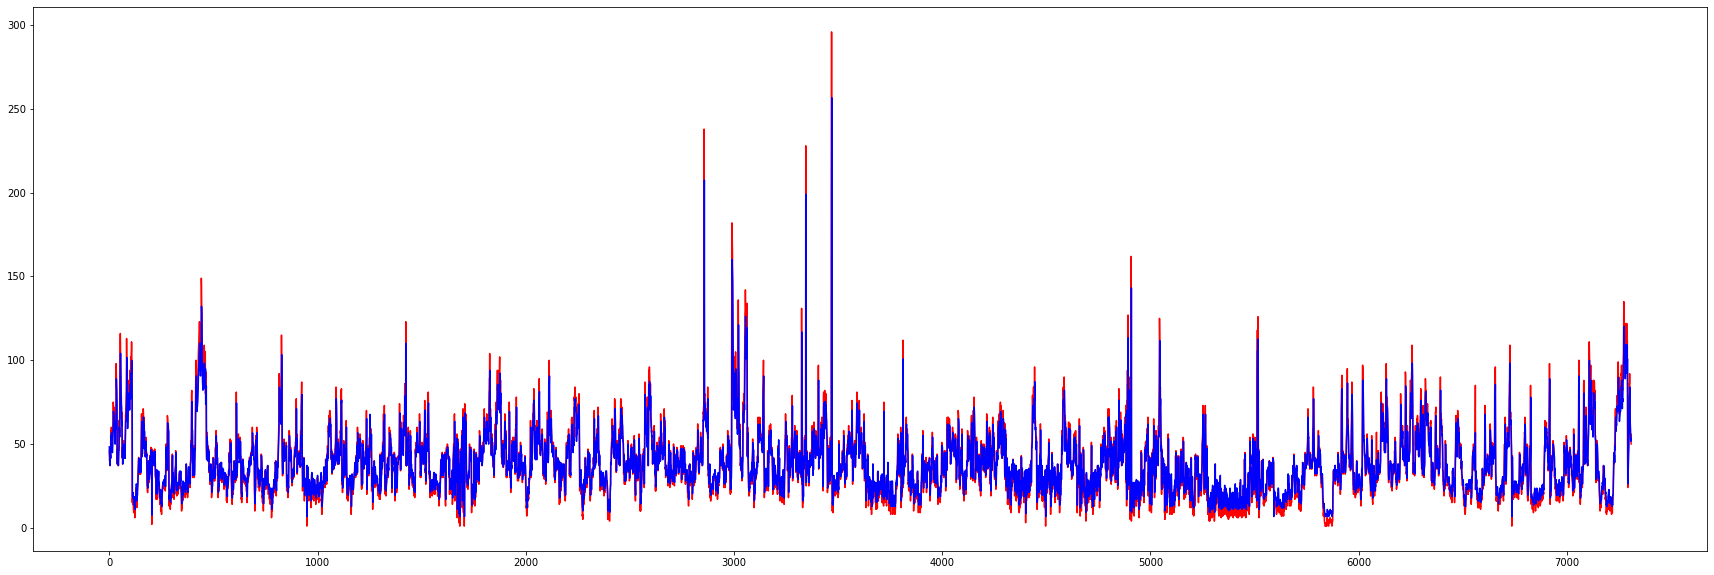

In [114]:
plt.figure(figsize=(30, 10))
plt.plot(X.reset_index().index, y.reset_index()['PM10_res'], color='red')
plt.plot(X.reset_index().index, model.predict(X), color='blue',)

plt.show()

### 처리 후 딥러닝

In [139]:
#단순 선형회귀로 먼저 테스트 해보기
#학습 데이터셋, 결과 데이터셋 만들기
#학습용(현재 PM10), 결과(1시간 후 PM10) 
X = shinamdong_drop[['PM10']].copy()
y = shinamdong_drop[['PM10_res']].copy()

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [141]:
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train -= X_mean
X_train /= X_std
X_test -= X_mean
X_test /= X_std

y_mean = y_train.mean(axis=0)
y_std = y_train.std(axis=0)
y_train -= y_mean
y_train /= y_std
y_test -= y_mean
y_test /= y_std

print(X_train, y_train)

           PM10
79085  1.382910
43555 -0.215660
54324  0.160474
2305   0.301525
42994 -0.591794
...         ...
33666  1.712028
19069 -0.497760
45150  1.429927
24888  1.523961
32225 -0.732844

[5848 rows x 1 columns]        PM10_res
79085  0.396753
43555 -0.073725
54324  5.807258
2305   0.161514
42994 -1.249922
...         ...
33666  1.337711
19069 -0.261917
45150  1.337711
24888  1.714093
32225 -0.779444

[5848 rows x 1 columns]


In [142]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(units=1, activation='relu', input_shape=(1,)),
                             tf.keras.layers.Dense(units=8, activation='relu'),
                             tf.keras.layers.Dense(units=8, activation='relu'),
                             tf.keras.layers.Dense(units=1),
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1)                 2         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 9         
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________


In [143]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='mse')

In [144]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')])

Epoch 1/100
147/147 [==============================] - 1s 2ms/step - loss: 0.8774 - val_loss: 0.6743
Epoch 2/100
147/147 [==============================] - 0s 1ms/step - loss: 0.5270 - val_loss: 0.3182
Epoch 3/100
147/147 [==============================] - 0s 1ms/step - loss: 0.2757 - val_loss: 0.2903
Epoch 4/100
147/147 [==============================] - 0s 1ms/step - loss: 0.2973 - val_loss: 0.2885
Epoch 5/100
147/147 [==============================] - 0s 1ms/step - loss: 0.2771 - val_loss: 0.2813
Epoch 6/100
147/147 [==============================] - 0s 1ms/step - loss: 0.2707 - val_loss: 0.2828
Epoch 7/100
147/147 [==============================] - 0s 1ms/step - loss: 0.2636 - val_loss: 0.2848
Epoch 8/100
147/147 [==============================] - 0s 1ms/step - loss: 0.2511 - val_loss: 0.2817
Epoch 9/100
147/147 [==============================] - 0s 1ms/step - loss: 0.2253 - val_loss: 0.2811
Epoch 10/100
147/147 [==============================] - 0s 1ms/step - loss: 0.2747 - val_lo

In [131]:
model.predict(X)

array([[48.425003],
       [45.025723],
       [39.926807],
       ...,
       [52.6741  ],
       [51.824284],
       [53.523914]], dtype=float32)

In [147]:
line_x = np.arange(min(X_test['PM10']), max(X_test['PM10']), 0.01)#.reshape(1, -1)
line_y=model.predict(line_x)

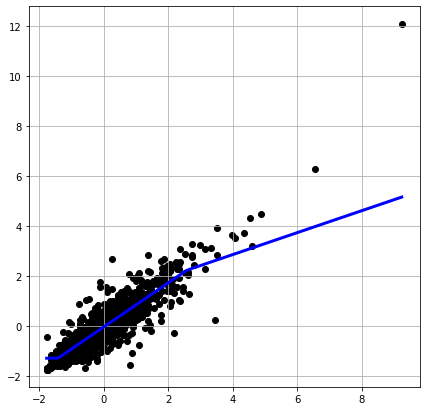

In [152]:
plt.figure(figsize=(7, 7))
plt.grid(True)
plt.scatter(X_test['PM10'], y_test['PM10_res'],  color='black')
#linex = [ [min(shinamdong_drop['PM10'])], [max(shinamdong_drop['PM10'])] ]
#line_x = np.arange(min(X_test['PM10']), max(X_test['PM10']), 0.01)
plt.plot(line_x, line_y, color='blue', linewidth=3)

plt.show()

In [150]:
y_pred = model.predict(X_test)
u = ((y_test - y_pred) ** 2).sum()
v = ((y_test - y_test.mean()) ** 2).sum()
R = 1 - (u / v)
R

PM10_res    0.776106
dtype: float64

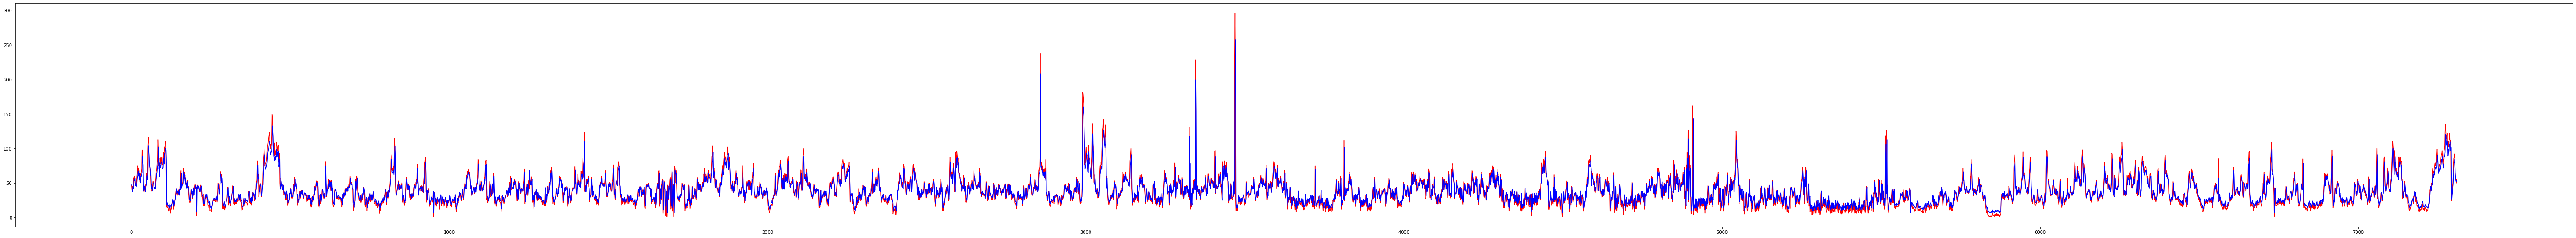

In [129]:
plt.figure(figsize=(100, 9))
plt.plot(y.reset_index().index, y.reset_index()['PM10_res'], color='red')
plt.plot(y.reset_index().index, model.predict(X), color='blue',)

plt.show()